In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
import torch
from torchvision import transforms

from data_utils import BMIDataset
from model import BMIPredictor
from solver import Solver

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import random
def set_seed(seed): 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 
    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed) 
    np.random.seed(seed) 
    random.seed(seed)
    
set_seed(40)

#### Check BMI statistics gender-wise on training data

             mean       std
gender                     
Female  33.113746  9.020173
Male    32.754963  8.196482


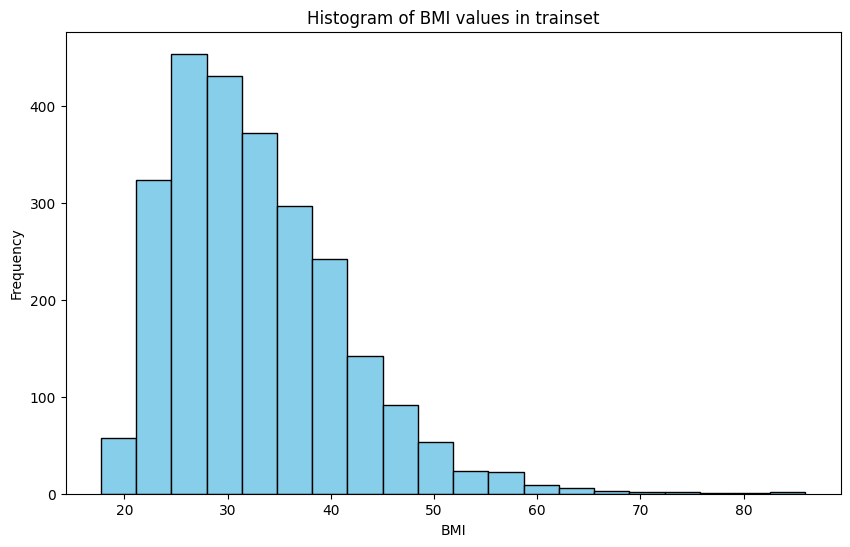

In [4]:
df = pd.read_csv('trainingset.csv')
bmi_stats = df.groupby('gender')['bmi'].agg(['mean', 'std'])

print(bmi_stats)

# Create the histogram of the 'bmi' column
plt.figure(figsize=(10, 6))
plt.hist(df['bmi'], bins=20, edgecolor='black', color='skyblue')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Histogram of BMI values in trainset')
plt.show()

In [5]:
# Fit Robust scalar to the training data. This will be used to transform inside Dataset class.
df = pd.read_csv('trainingset.csv')
scaler = RobustScaler()
scaler.fit(np.array(df['bmi']).reshape(-1, 1))

RobustScaler()

In [6]:
# Define Image Transformations for training and validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Datasets
train_data = BMIDataset("trainingset.csv", "Images/CodingImages", scaler, transform=train_transforms, use_gender=True)
val_data = BMIDataset("validationset.csv", "Images/CodingImages", scaler, transform=val_transforms, use_gender=True)

#### Visualize training data

Train size: 2536
Val size: 634


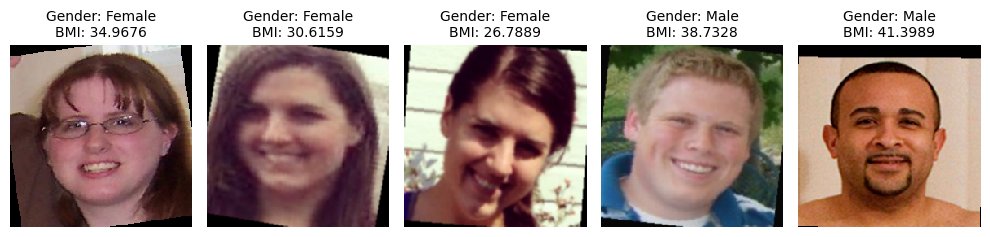

In [7]:
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))

# Visualization
num_example_imgs = 5
for i, (img, gender, bmi) in enumerate(train_data[:num_example_imgs]):  # Use slicing instead of range

    plt.subplot(1, num_example_imgs, i + 1)  # Arrange images in a row
   
    # Unnormalize (Clone before modifying)
    img = img.clone()
    img[0] = img[0] * 0.229 + 0.485
    img[1] = img[1] * 0.224 + 0.456
    img[2] = img[2] * 0.225 + 0.406

    # Convert to numpy and plot
    plt.imshow(img.permute(1, 2, 0).numpy())  
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

    gender_str = "Male" if gender.tolist() == [1, 0] else "Female" if gender.tolist() == [0, 1] else "Unknown"
    # inverse bmi to original value
    original_bmi = scaler.inverse_transform(bmi.reshape(-1, 1)).flatten()[0]

    plt.title(f'Gender: {gender_str}\nBMI: {original_bmi.item():.4f}', fontsize=10)

plt.tight_layout()
plt.show()

### Training

START TRAIN.
Epoch  0  Train Loss  1.7278894046879718  Val Loss  1.390640143716373  LR  0.0001
Epoch  1  Train Loss  1.2861458661052332  Val Loss  1.2390858615610503  LR  0.0001
Epoch  2  Train Loss  1.0894231194577382  Val Loss  1.2938969492536239  LR  0.0001
Epoch  3  Train Loss  0.9727782044877014  Val Loss  1.2669586879597854  LR  0.0001
Epoch  4  Train Loss  0.8753949949041903  Val Loss  1.2002208033570732  LR  0.0001
Epoch  5  Train Loss  0.8036720168891389  Val Loss  1.2638183993872032  LR  0.0001
Epoch  6  Train Loss  0.7263509429967742  Val Loss  1.1331400329758317  LR  0.0001
Epoch  7  Train Loss  0.679557886597486  Val Loss  1.1521619750122167  LR  0.0001
Epoch  8  Train Loss  0.6473547498510464  Val Loss  1.1871543547332475  LR  0.0001
Epoch  9  Train Loss  0.6181061113670421  Val Loss  1.1264514862926978  LR  0.0001
Epoch  10  Train Loss  0.5885514513551249  Val Loss  1.1679560701929808  LR  0.0001
Epoch  11  Train Loss  0.5915702615250549  Val Loss  1.1120382521054721  LR

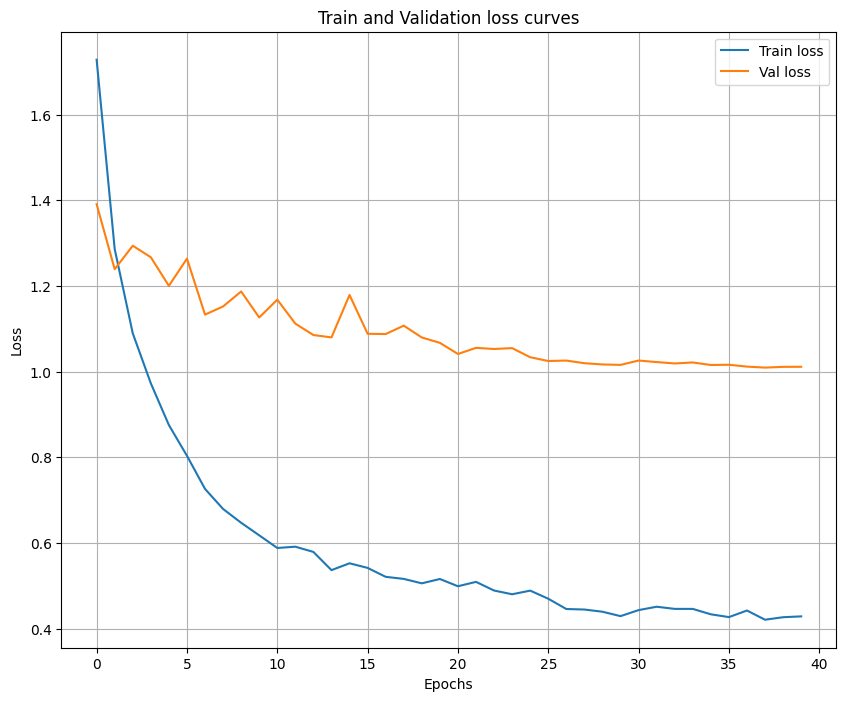

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

model = BMIPredictor()
solver = Solver()
solver.train(model, train_dataloader, val_dataloader, num_epochs=40)

In [9]:
model.save("models/bmiprediction_mobilnetv3large_epoch40.model")

Saving model state to models/bmiprediction_mobilnetv3large_epoch40.model


### Testing the model performance

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# note that gender information is not know during inference
test_data = BMIDataset("validationset.csv", "Images/CodingImages", scaler, transform=test_transforms, use_gender=False)

# load trained model
model = BMIPredictor()
model.load_state_dict(torch.load("models/bmiprediction_mobilnetv3large_epoch40.model", map_location=torch.device('cpu')))
model.to(device)
model.eval()

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

true_bmis = []
predicted_bmis_list = []
for images, genders, targets in test_dataloader:
    images, genders, targets = images.to(device), genders.to(device), targets.to(device)
    
    # predicted genders are not needed
    _, predicted_bmi = model(images)

    true_bmis.extend(targets.cpu().numpy())
    predicted_bmis_list.extend(predicted_bmi.detach().cpu().numpy())

# convert to original scale of BMI using inverse transform
true_bmis = np.array(true_bmis)
true_bmis = scaler.inverse_transform(true_bmis.reshape(-1, 1)).flatten()
predicted_bmis = np.array(predicted_bmis_list)
predicted_bmis = scaler.inverse_transform(predicted_bmis.reshape(-1, 1)).flatten()

# Compute Regression Metrics
mae = mean_absolute_error(true_bmis, predicted_bmis)
mse = mean_squared_error(true_bmis, predicted_bmis)
rmse = mse ** 0.5
r2 = r2_score(true_bmis, predicted_bmis)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 4.4190
Mean Squared Error (MSE): 33.9775
Root Mean Squared Error (RMSE): 5.8290
R² Score: 0.4330


#### Export model to onnx format (optional)

In [12]:
model.export(model, device, file_name="models/bmiprediction_mobilnetv3large_epoch40.onnx")